# Import

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
import os
import torchvision
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import sample
import numpy as np
import torch.nn as nn
%pylab inline
import matplotlib.image as mpimg
import imutils
import dlib
import cv2
import pickle
import time
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# if you dont have the folder 'eameo-faceswap-generator', run this cell
!git clone https://github.com/nicolasmetallo/eameo-faceswap-generator

Cloning into 'eameo-faceswap-generator'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (16/16), done.
remote: Total 266 (delta 15), reused 15 (delta 15), pack-reused 250
Receiving objects: 100% (266/266), 168.59 MiB | 35.04 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [ ]:
# precentage of the train set
TRAIN = 0.8

# precentage of data to cut from the data set
CUT = 0.0

d = {
    "train": list(),
    "val": list(),
    "test": list(),
}

emotions = {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "joy": 3,
    "neutral": 4,
    "sadness": 5,
    "surprise": 6
}

# path to the original image folder
imgs_path = "/content/drive/MyDrive/deep_project_data/tmp/FERG_DB_256"

# path of where we want to save the data
path = "/content/drive/MyDrive/deep_project_data/"

If you already have the pickle files of the train, validation and test sets. you DON'T need to run the "Preprocessing and Saving the Data" section

# Preprocessing and Saving the Data

In [ ]:
from random import sample

# read all the images, and split them to train, validation and test sets
count = 0
persons = [f for f in os.listdir(imgs_path) if os.path.isdir(os.path.join(imgs_path, f))]
for person in tqdm(persons):
    for emotion in emotions.keys():
        temp_path = os.path.join(imgs_path, person, f"{person}_{emotion}/")
        pics_paths = [f for f in os.listdir(
            temp_path) if os.path.isfile(os.path.join(temp_path, f))]
        pics = []
        for pic in pics_paths:
            pic_path = os.path.join(temp_path, pic)
            image = cv2.imread(pic_path)
            image = imutils.resize(image, width=image.shape[0], height=image.shape[1])
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            pics.append(gray)
        count += len(pics)
        # cut
        n_cut = int(CUT * len(pics))
        inx = sample(range(len(pics)), n_cut)
        final_pics = []
        for i in range(len(pics)):
            if i not in inx:
                final_pics.append(pics[i])

        # train test split
        n = int(TRAIN * len(pics))
        inx = sample(range(len(pics)), n)
        for i in range(len(final_pics)):
            data = (final_pics[i], emotions[emotion])
            if i in inx:
                d["train"].append(data)
            else:
                inx2 = np.random.rand(1)
                if inx2[0] > 0.5:
                    d["test"].append(data)
                else:
                    d["val"].append(data)


print(f"total pics {count} before")
count = 0
for key, val in d.items():
    s = set()
    l = len(val)
    count += l
    for img, label in val:
        s.add(label)
    print(f"in {key}, there is total of {l} pics and labels {s}")
print(f"total images after {count}")

100%|██████████| 6/6 [20:11<00:00, 201.89s/it]

total pics 55768 before
in train, there is total of 44600 pics and labels {0, 1, 2, 3, 4, 5, 6}
in val, there is total of 5572 pics and labels {0, 1, 2, 3, 4, 5, 6}
in test, there is total of 5596 pics and labels {0, 1, 2, 3, 4, 5, 6}
total images after 55768


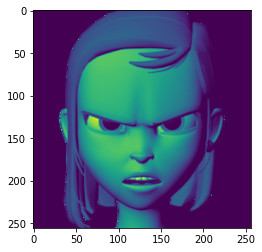

In [ ]:
# print a sample image
plt.imshow(d["train"][0][0])

In [ ]:
# the pixels for the detection of the mouth, eyebrows and eyes
MOUTH = (48,68)
LEFT_EYEBROW = (22, 27)
RIGHT_EYEBROW = (17, 22)
LEFT_EYE = (42, 48)
RIGHT_EYE = (36, 42)

In [ ]:
def get_critical_points(points):
  left_point = points[0]
  right_point = [0,0]
  lower_point = points[0]
  upper_point = [0,0]
  
  for p in points:
    if p[0] < left_point[0]:
      left_point = p 
    if p[0] > right_point[0]:
      right_point = p
    if p[1] < lower_point[1]:
      lower_point = p
    if p[1] > upper_point[1]:
      upper_point = p
  return left_point, right_point, lower_point, upper_point

In [ ]:
def to_bb(critical_points):
	left = (critical_points[0][0], critical_points[1][0])
	right = (critical_points[1][1], critical_points[3][1])

	return left, right

In [ ]:
def get_detector_points(image):    
    rects = detector(image,1)
    if len(rects) == 0:
      # plt.imshow(image)
      return None
    shape = predictor(image, rects[0])
    face_points = []
    for part in shape.parts():
        face_points.append((part.x, part.y))
    np_face_points = np.array(face_points)
    mouse = np_face_points[MOUTH[0]:MOUTH[1]]
    upper_points = mouse
    left_eye = np_face_points[LEFT_EYE[0]:LEFT_EYE[1]]
    right_eye = np_face_points[RIGHT_EYE[0]:RIGHT_EYE[1]]
    left_eyebrow = np_face_points[LEFT_EYEBROW[0]:LEFT_EYEBROW[1]]
    right_eyebrow = np_face_points[RIGHT_EYEBROW[0]:RIGHT_EYEBROW[1]]
    lower_points = np.concatenate((left_eye, right_eye, left_eyebrow, right_eyebrow))
    return lower_points, upper_points

In [ ]:
def get_blocks(lst):
  """
    lst[(image, label)]
    lst[(lower_block, upper_block, label)]
  """
  X_WINDOW = 30
  Y_WINDOW = 30
  blocks = []
  for l in tqdm(lst):
    img = l[0]
    tmp = get_detector_points(img)
    if tmp != None:
        lower_points, upper_points = tmp 
        critical_upper = get_critical_points(upper_points)
        upper = to_bb(critical_upper)
        upper_block_image = gray[upper[1][0]-X_WINDOW:upper[1][1]+X_WINDOW, upper[0][0]-Y_WINDOW:upper[0][1]+Y_WINDOW]    
        
        critical_lower = get_critical_points(lower_points)
        lower = to_bb(critical_lower)
        lower_block_image = gray[lower[1][0]-X_WINDOW:lower[1][1]+X_WINDOW, lower[0][0]-Y_WINDOW:lower[0][1]+Y_WINDOW] 
          
        blocks.append((upper_block_image, lower_block_image, l[1]))
        

  return blocks

In [ ]:
# create the detector and predictor objects
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/eameo-faceswap-generator/shape_predictor_68_face_landmarks.dat")

In [ ]:
# get the blocks for the train, validation and test sets
for key, val in d.items():
    print(f"getting blocks for {key}")
    d[key] = get_blocks(val)

getting blocks for train


100%|██████████| 44600/44600 [34:45<00:00, 21.39it/s]


getting blocks for val


100%|██████████| 5572/5572 [04:22<00:00, 21.20it/s]


getting blocks for test


100%|██████████| 5596/5596 [04:21<00:00, 21.43it/s]


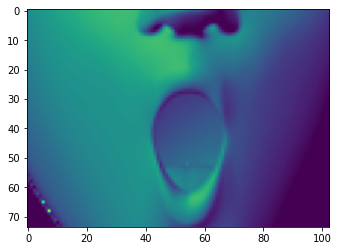

In [ ]:
# print a sample images
plt.imshow(d["train"][0][0])

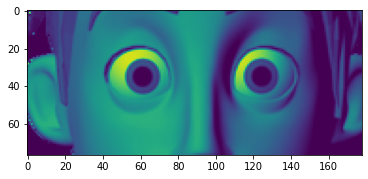

In [ ]:
plt.imshow(d["train"][0][1])

In [ ]:
# for some images, the detector didn't recognize the eyes, eyebrows or mouth so we remove them from the data
count = 0
for key, val in d.items():
    s = set()
    l = len(val)
    count += l
    for img1, img2, label in val:
        s.add(label)
    print(f"in {key}, there is total of {l} pics and labels {s}")
print(f"total images {count}")

in train, there is total of 44148 pics and labels {0, 1, 2, 3, 4, 5, 6}
in val, there is total of 5519 pics and labels {0, 1, 2, 3, 4, 5, 6}
in test, there is total of 5534 pics and labels {0, 1, 2, 3, 4, 5, 6}
total images 55201


In [ ]:
def save_blocks(dictionary_data, filepath):
    """
    The function saves the data in the dictionary on a pickle file
    Args:
        dictionary_data - the data we want to save
        filepath - the path
    """
    for key, val in tqdm(dictionary_data.items()):
        a_file = open(f"{filepath}final{key}.pkl", "wb")
        pickle.dump(dictionary_data[key], a_file)
        a_file.close()

In [ ]:
# save the data in a pickle file
save_blocks(d, path)

100%|██████████| 3/3 [00:26<00:00,  8.93s/it]


# Loading the Data

In [ ]:
# load the data from the pickle file
final_d = {"train": None, "test": None, "val": None}
for key in final_d.keys():
        a_file = open(f"{path}final{key}.pkl", "rb")
        output = pickle.load(a_file)
        final_d[key] = output

In [ ]:
# checking we don't mess up :)
count = 0
for key, val in final_d.items():
    s = set()
    l = len(val)
    count += l
    for img1, img2, label in val:
        s.add(label)
    print(f"in {key}, there is total of {l} pics and labels {s}")
print(f"total images {count}")

in train, there is total of 44148 pics and labels {0, 1, 2, 3, 4, 5, 6}
in test, there is total of 5534 pics and labels {0, 1, 2, 3, 4, 5, 6}
in val, there is total of 5519 pics and labels {0, 1, 2, 3, 4, 5, 6}
total images 55201


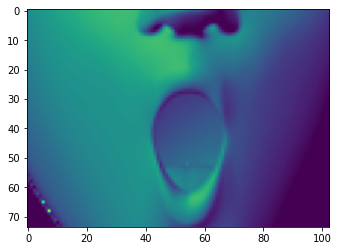

In [ ]:
# print a sample images
plt.imshow(final_d["train"][0][0])

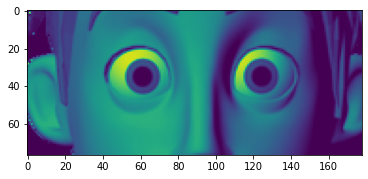

In [ ]:
plt.imshow(final_d["train"][0][1])

# Dataset

In [ ]:
# The dataset class
class PlainDataset(Dataset):
    def __init__(self, data, upper_transform=None, lower_transform=None):
        """
        PyTorch dataset class
        Args:
            data - list(tuple(upper_img, lower_img, label))
        Return:
            image, labels
        """
        self.upper_transform = upper_transform
        self.lower_transform = lower_transform
        self.upper_imgs = [img for img, _, _ in data]
        self.lower_imgs = [img for _, img, _ in data]
        self.labels = [label for _, _, label in data]
        assert (len(self.upper_imgs) == len(self.lower_imgs)
                and len(self.lower_imgs) == len(self.labels))

    def __len__(self):
        return len(self.upper_imgs)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()


        labels = np.array(self.labels[index])
        labels = torch.from_numpy(labels).long()
        if self.upper_transform:
            upper_img = self.upper_transform(self.upper_imgs[index])
        if self.lower_transform:
            lower_img = self.lower_transform(self.lower_imgs[index])

        return upper_img, lower_img, labels

# Create DataLoaders

In [ ]:
# define the batch size
batch_size = 64

In [ ]:
# convert the images to PIL.Image object
final_data = {"train": list(), "test": list(), "val": list()}
for key, val in final_d.items():
    for ui, li, label in val:
        rui = Image.fromarray(ui)
        rli = Image.fromarray(li)
        final_data[key].append((rui, rli, label))

In [ ]:
# checking we don't mess up :)
count = 0
for key, val in final_data.items():
    s = set()
    l = len(val)
    count += l
    for img1, img2, label in val:
        s.add(label)
    print(f"in {key}, there is total of {l} pics and labels {s}")
print(f"total images {count}")

in train, there is total of 44148 pics and labels {0, 1, 2, 3, 4, 5, 6}
in test, there is total of 5534 pics and labels {0, 1, 2, 3, 4, 5, 6}
in val, there is total of 5519 pics and labels {0, 1, 2, 3, 4, 5, 6}
total images 55201


In [ ]:
# define the transformation for the upper and lower images
u_t = transforms.Compose([transforms.Resize((32, 32)),transforms.ToTensor(),transforms.Normalize(0, 0.5)])
l_t = transforms.Compose([transforms.Resize((32, 32)),transforms.ToTensor(),transforms.Normalize(0, 0.5)])

In [ ]:
# create the dataset for the train, validation and test sets
train_data = PlainDataset(final_data["train"], u_t, l_t)
val_data = PlainDataset(final_data["val"], u_t, l_t)
test_data = PlainDataset(final_data["test"], u_t, l_t)
# create the data loaders for the train , validation and test sets
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle = True,num_workers=0)
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle = True,num_workers=0)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle = True,num_workers=0)

In [ ]:
# print example batch
for img1, img2, label in train_loader:
    print(img1.shape)
    print(img2.shape)
    break

torch.Size([64, 1, 32, 32])
torch.Size([64, 1, 32, 32])


# Architecture

In [ ]:
# The proposed architecture
class TerGat(nn.Module):
  def __init__(self, latent_dim=100):
    
    super(TerGat, self).__init__()
    self.lower_conv_layer = nn.Sequential(
    # Conv Layer block 1
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.lower_fc_layer = nn.Sequential(
      nn.Dropout(p=0.1),
      nn.Linear(16384, 1024),
      nn.ReLU(inplace=True),
      nn.Linear(1024, 512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      nn.Linear(512, latent_dim)
    )
    self.upper_conv_layer = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.upper_fc_layer = nn.Sequential(
      nn.Dropout(p=0.1),
      nn.Linear(16384, 1024),
      nn.ReLU(inplace=True),
      nn.Linear(1024, 512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      nn.Linear(512, latent_dim)
    )

    self.final_fc = nn.Sequential(
      nn.Dropout(p=0.1),
      nn.Linear(2*latent_dim, 1024),
      nn.ReLU(inplace=True),
      nn.Linear(1024, 512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      nn.Linear(512, 7)
    )

  def forward(self, lower_block, upper_block):
    """Perform forward."""

    # conv layers
    lower_x = self.lower_conv_layer(lower_block)

    # flatten
    lower_x = lower_x.view(lower_x.size(0), -1)

    # fc layer
    lower_x = self.lower_fc_layer(lower_x)
    # conv layers
    upper_x = self.upper_conv_layer(upper_block)
    # flatten
    upper_x = upper_x.view(upper_x.size(0), -1)

    # fc layer
    upper_x = self.upper_fc_layer(upper_x)

    final = self.final_fc(torch.cat((lower_x, upper_x), axis=1))
    return final

# Training Loop


In [ ]:
# define the model
model = TerGat(latent_dim=100).to(device)

In [ ]:
# define the hyperparameters
epochs = 50
lr = 1e-3

# define the criterion and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device, criterion):
    """
    Helper function to calculate accuracy of the model
    Args:
        model - the selected model
        dataloader - the dataloader to calculate the accuracy on
        device - the device
        criterion - the loss function
    Return:
        the loss and accuracy of the model on the given data, and the confusion matrix
    """
    model.eval() # put in evaluation mode
    total_correct = 0
    running_loss = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            ui, li, labels = data
            ui = ui.to(device)
            li = li.to(device)
            labels = labels.to(device)
            outputs = model(ui, li)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            running_loss += loss.data.item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 
    # print(f"total corrected {total_correct}, total images in data {total_images}, diff {total_images - total_correct}")
    model_accuracy = total_correct / total_images * 100
    running_loss /= len(dataloader)
    return running_loss, model_accuracy, confusion_matrix

In [ ]:
# training loop
train_accs, test_accs = [], []
train_losses = []
val_losses = []
print('==> Start Training ...')
for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        ui, li, labels = data
        # send them to device
        ui = ui.to(device)
        li = li.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(ui, li)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(train_loader)
    train_losses.append(running_loss)
    
    # Calculate training/test set accuracy of the existing model
    _, train_accuracy, _ = calculate_accuracy(model, train_loader, device, criterion)
    val_loss, val_accuracy, _ = calculate_accuracy(model, val_loader, device, criterion)
    val_losses.append(val_loss)
    train_accs.append(train_accuracy)
    test_accs.append(val_accuracy)
    log = "Epoch: {} | Train Loss: {:.4f} | Validation Loss: {:.4f} |Training accuracy: {:.3f}% | Validation accuracy: {:.3f}% | ".format(epoch, running_loss, val_loss, train_accuracy, val_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

print('==> Finished Training ...')

==> Start Training ...
Epoch: 1 | Train Loss: 0.3953 | Validation Loss: 0.2129 |Training accuracy: 93.846% | Validation accuracy: 93.042% | Epoch Time: 53.54 secs
Epoch: 2 | Train Loss: 0.1810 | Validation Loss: 0.1941 |Training accuracy: 95.017% | Validation accuracy: 94.093% | Epoch Time: 53.02 secs
Epoch: 3 | Train Loss: 0.1522 | Validation Loss: 0.1264 |Training accuracy: 96.845% | Validation accuracy: 96.159% | Epoch Time: 52.95 secs
Epoch: 4 | Train Loss: 0.1334 | Validation Loss: 0.1134 |Training accuracy: 97.391% | Validation accuracy: 96.485% | Epoch Time: 53.16 secs
Epoch: 5 | Train Loss: 0.1180 | Validation Loss: 0.1217 |Training accuracy: 97.470% | Validation accuracy: 96.467% | Epoch Time: 52.64 secs
Epoch: 6 | Train Loss: 0.1085 | Validation Loss: 0.1133 |Training accuracy: 97.366% | Validation accuracy: 96.630% | Epoch Time: 52.50 secs
Epoch: 7 | Train Loss: 0.0939 | Validation Loss: 0.1255 |Training accuracy: 97.533% | Validation accuracy: 96.557% | Epoch Time: 52.43 se

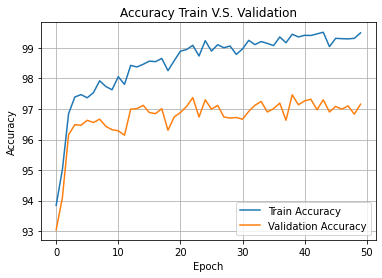

In [ ]:
res_path = "/content/drive/MyDrive/deep_project_data/res/"
if not os.path.exists(res_path):
    os.mkdir(res_path)

# plot a comparsion of the train and validation accuracy
plt.plot(list(range(epochs)), train_accs, label="Train Accuracy")
plt.plot(list(range(epochs)), test_accs, label="Validation Accuracy")
plt.title("Accuracy Train V.S. Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.savefig(f"{res_path}/TerGat_accuracy_{epochs}_{lr}_{batch_size}.png")
plt.show()

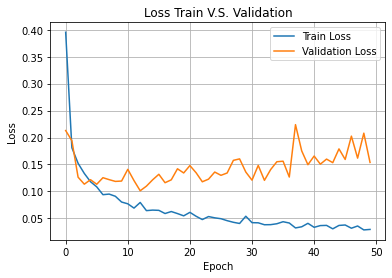

In [33]:
res_path = "/content/drive/MyDrive/deep_project_data/res/"
if not os.path.exists(res_path):
    os.mkdir(res_path)

# plot a comparsion of the train and validation loss
plt.plot(list(range(epochs)), train_losses, label="Train Loss")
plt.plot(list(range(epochs)), val_losses, label="Validation Loss")
plt.title("Loss Train V.S. Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.savefig(f"{res_path}/TerGat_loss_{epochs}_{lr}_{batch_size}.png")
plt.show()

In [ ]:
# get the model test accuracy and confusion matrix
_, test_accuracy, test_confusion = calculate_accuracy(model, test_loader, device, criterion)

In [ ]:
print(f"accuracy on Test set is {test_accuracy:.3f}%")

accuracy on Test set is 97.506%


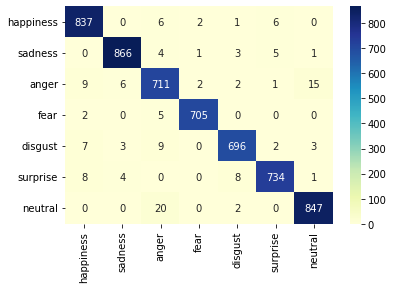

In [32]:
# plot the test confusion matrix
test_confusion = test_confusion[:7, :7]
emotions = ["happiness", "sadness", "anger", "fear", "disgust", "surprise", "neutral"]
df_d = {e: test_confusion[i, :] for i, e in enumerate(emotions)}
df = pd.DataFrame(df_d, index=emotions)

sns.heatmap(df, fmt="d", cmap="YlGnBu", annot=True)
plt.savefig(f"{res_path}/heatmap_{epochs}_{lr}_{batch_size}.png")